In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [8]:
#Q1 Hough transform
def nothing(x):
    pass

# create window contain trackbar
windowname="circle"
cv.namedWindow(windowname)
cv.moveWindow(windowname,100,100)

#control accumulater threshold, length,gap
cv.createTrackbar("param1", windowname,144,200,nothing)
cv.createTrackbar("param2", windowname,21,200,nothing)

#load image and do some preprocessing
img = cv.imread('coins_1.jfif')
blur = cv.medianBlur(img,5)
gray = cv.cvtColor(blur,cv.COLOR_BGR2GRAY)

while 1:
    #get trackbar values
    param1= cv.getTrackbarPos("param1", windowname)
    param2 = cv.getTrackbarPos("param2", windowname)    
    
    #Hough line transform
    row = img.shape[0]
    circles = cv.HoughCircles(gray,cv.HOUGH_GRADIENT,1,row/8,param1=param1, param2 = param2)
    
    img_copy = img.copy()
    
    #draw
    if circles is not None:
        circles = np.uint8(np.around(circles))
        for i in circles[0]:
            #draw the center of the circle
            center = (i[0],i[1])
            cv.circle(img_copy,center,1,(100,100,100),2)
            #draw the whole circle
            radius = i[2]
            cv.circle(img_copy,center,radius,(255,0,0),2)
        
    cv.imshow(windowname, img_copy)
    k= cv.waitKey(1)& 0xFF
    if k==27:
        break
cv.destroyAllWindows()

param1 =144, param2 = 21
- all of the coin able to be detected with the param1 and param2 shown above. However some part of the coin area are out of the detected area.

In [9]:
#Q1 Blob detection
# Area, circularity, repeatability and minDist
def nothing(x):
    pass

window_name = "Blob detection"
cv.namedWindow(window_name)
cv.createTrackbar('min area', window_name, 60, 100, nothing)
cv.createTrackbar('min repeatability', window_name, 5, 20, nothing)
# cv.createTrackbar('min distance between blobs', window_name, 30, 100, nothing)

img = cv.imread('coins_1.jfif')
img = cv.medianBlur(img, 3)
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
img_sharpen = cv.filter2D(img, -1, kernel)
gray = cv.cvtColor(img_sharpen, cv.COLOR_BGR2GRAY)
#clahe = cv.createCLAHE(clipLimit = 3, tileGridSize = (8, 8))
gray = cv.equalizeHist(gray)

while 1:
    min_area = cv.getTrackbarPos('min area', window_name)
    min_area = 10*min_area
    min_repeat = cv.getTrackbarPos('min repeatability', window_name)
    if min_repeat == 0:
        break
    
    params = cv.SimpleBlobDetector_Params()
    params.filterByColor = True
    params.blobColor = 255
    
    params.minThreshold = 10
    params.maxThreshold = 250
    params.thresholdStep = 5
    
    params.filterByArea = True
    params.minArea = min_area

    params.filterByConvexity = False
    
    params.filterByInertia = False
    
    params.minRepeatability = min_repeat
    
    detector = cv.SimpleBlobDetector_create(params)
    keypoints = detector.detect(gray)
    
    im_with_keypoints = cv.drawKeypoints(img, keypoints, np.zeros([]), (0, 255, 0),
                                        cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    cv.imshow(window_name, im_with_keypoints)
    k = cv.waitKey(1) & 0xFF
    if k == 27:
        break

cv.destroyAllWindows()

- all coin able to be detected by the parameter setting above. However, some detections detect the region that is not belong to the coin

In [11]:
#Q2
img = cv.imread('zebra.jfif')
img = cv.GaussianBlur(img, (3, 3), 0)
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)


# 2 helper functions
def centroid_histogram(clust_labels):
    # Create histogram based on the number of pixels assigned to each cluster
    numLabels = len(np.unique(clust_labels))
    hist, _ = np.histogram(clust_labels, bins = numLabels)
    
    # Normalize the histogram, such that it sums to one
    hist = hist.astype("float32")
    hist /= hist.sum()
    
    return hist

def plot_colors(hist, centroids):
    # Initialize bar chart representing relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype = np.uint8)
    startX = 0
    
    # loop over the percentage of each cluster and the color of each cluster
    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent*300)
        cv.rectangle(bar, (int(startX), 0), (int(endX), 50),
                    color.astype("uint8").tolist(), -1)
        startX = endX
        
    # return bar chart
    return bar

In [12]:
img_reshape_rgb = img_rgb.reshape((-1, 3))
img_reshape_hsv = img_hsv.reshape((-1, 3))


In [13]:
#calculate the wcss
from sklearn.cluster import KMeans
wcss_rgb = []
wcss_hsv = []
for i in range(2, 11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(img_reshape_rgb)
    wcss_rgb.append(kmeans.inertia_)    
    kmeans.fit(img_reshape_hsv) 
    wcss_hsv.append(kmeans.inertia_)    


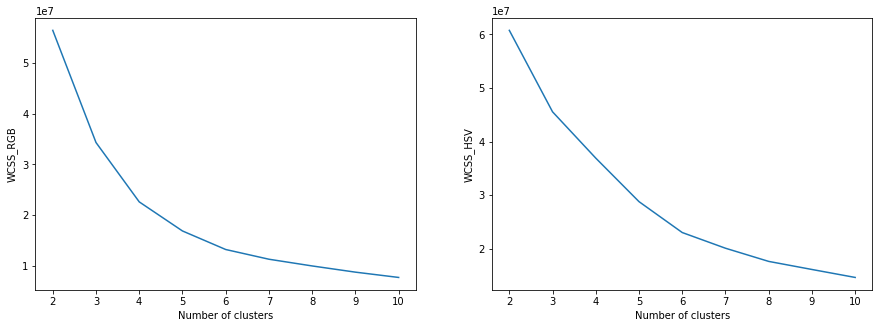

In [14]:
#plot the graph
plt.figure(figsize = (15, 5))
plt.subplot(1,2,1)
plt.plot(range(2, 11), wcss_rgb)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS_RGB')
plt.subplot(1,2,2)
plt.plot(range(2, 11), wcss_hsv)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS_HSV') 
plt.show()

- by refering to the graph k=6 is picked as the optimal k

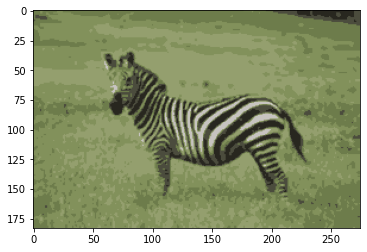

In [15]:
#RGB
img_reshape_rgb = np.float32(img_reshape_rgb)

# Define criteria, attempts and number of clusters
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
attempts = 10
K = 6

ret, label, center = cv.kmeans(img_reshape_rgb, K, None, criteria, attempts, cv.KMEANS_PP_CENTERS)

# Convert the center to np.uint8
center = np.uint8(center)
res = center[label.flatten()]
result_img = res.reshape(img_rgb.shape)
plt.imshow(result_img)
plt.show()

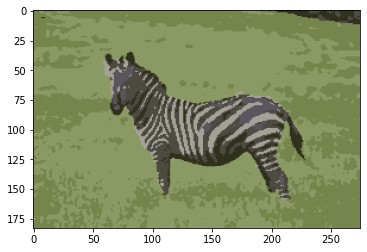

In [18]:
#HSV
img_reshape_hsv = np.float32(img_reshape_hsv)

# Define criteria, attempts and number of clusters
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
attempts = 10
K = 6

ret, label2, center2 = cv.kmeans(img_reshape_hsv, K, None, criteria, attempts, cv.KMEANS_PP_CENTERS)

# Convert the center to np.uint8
center2 = np.uint8(center2)
res2 = center2[label2.flatten()]
result_img2 = res2.reshape(img_hsv.shape)

plt.imshow(cv.cvtColor(result_img2, cv.COLOR_HSV2RGB))
plt.show()

In [19]:
center

array([[130, 145,  91],
       [ 75,  76,  61],
       [148, 159, 110],
       [199, 196, 192],
       [ 40,  39,  31],
       [109, 124,  75]], dtype=uint8)

In [20]:
center2

array([[ 38, 108, 133],
       [ 24,  18, 164],
       [ 24,  36,  77],
       [140,  21,  94],
       [ 38,  87, 154],
       [ 31,  99,  49]], dtype=uint8)

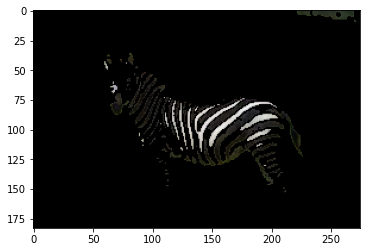

In [21]:
#RGB
from numpy import linalg as LN

white_color = (255,255,255)
idx = np.argmin(LN.norm(white_color-center,axis=1))
idx2 = np.argmax(LN.norm(white_color-center,axis=1))
mask_w = result_img==center[idx]
mask_b = result_img==center[idx2]

f_mask= mask_b+mask_w
seg_img = img_rgb*(f_mask.astype("uint8"))

plt.imshow(seg_img)
plt.show()


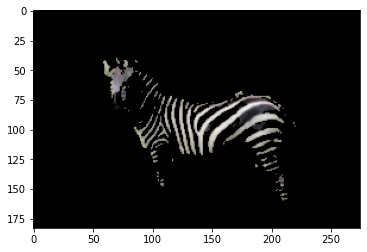

In [23]:
#HSV
dark = (180, 18, 255)
light = (0,0,231)

idx = np.argmin(LN.norm(dark-center2,axis=1))
idx2 = np.argmin(LN.norm(light-center2,axis=1))
mask_w = result_img2==center2[idx]
mask_b = result_img2==center2[idx2]

f_mask= mask_b+mask_w
seg_img2 = img_hsv*(f_mask.astype("uint8"))
seg_img2=cv.cvtColor(seg_img2,cv.COLOR_HSV2RGB)

plt.imshow(seg_img2)
plt.show()

- Clustering using HSV color space is better than the RGB. HSV show a more clearer segentation and low noise